In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from test_utils import test
from typing import NamedTuple, List, Dict, Tuple

In /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.

# Load the data

We will be working with the MovieLens dataset, containing 100k movie ratings.
The goal is to predict the rating of a (movie, user) pair, given other ratings by this user and of this movie.

In [2]:
class Dataset(NamedTuple):
    """Data container with three arrays of the same length:"""
    movies: np.ndarray
    users: np.ndarray
    ratings: np.ndarray

def load_data() -> Dataset:
    """Load a sparse matrix from a matlab file and return is as a list of """
    data = scipy.io.loadmat('movielens100k.mat')["ratings"]
    movies, users = data.nonzero()  # indices of available ratings in the matrix
    ratings = data[movies, users].A1
    return Dataset(movies, users, ratings)

dataset = load_data()

num_users = np.max(dataset.users) + 1
num_movies = np.max(dataset.movies) + 1

print(f"Loaded {len(dataset.ratings)} ratings of {num_users} users for {num_movies} movies.")

Loaded 100000 ratings of 943 users for 1682 movies.


# Plot the number of ratings per movie and user

It will be too tricky to make predictions for movies and users for which too few ratings are available.
Below we will investigate the distribution of how many ratings we have for various users and movies, to evaluate if we need to exclude some users or movies.

In [3]:
def count_ratings_per_movie(dataset: Dataset) -> Dict[int, int]:
    """Count the number of ratings available per movie
    
    Inputs:
        dataset: Dataset
    
    Returns:
        counts: a dictionary form movie id (int) -> count (int)
    
    >>> count_ratings_per_movie(Dataset(np.array([0, 0, 1]), np.array([1, 2, 1]), np.array([1.0, 2.0, 3.0])))
    {0: 2, 1: 1}
    """
    counts = {}
    unique, unique_counts = np.unique(dataset.movies, return_counts=True)
    counts = dict(zip(unique, unique_counts))
    return counts

def count_ratings_per_user(dataset: Dataset) -> Dict[int, int]:
    """Count the number of ratings given by a user
    
    Inputs:
        dataset: Dataset
    
    Returns:
        counts: a dictionary form user id (int) -> count (int)
    
    >>> count_ratings_per_user(Dataset(np.array([0, 0, 1]), np.array([1, 2, 2]), np.array([4.0, 1.0, 2.0])))
    {1: 1, 2: 2}
    """
    counts = {}
    unique, unique_counts = np.unique(dataset.users, return_counts=True)
    counts = dict(zip(unique, unique_counts))
    return counts

In [4]:
test(count_ratings_per_movie)
test(count_ratings_per_user)

✅ Your `count_ratings_per_movie` passes some basic tests.
✅ Your `count_ratings_per_user` passes some basic tests.


Let's plot the results:

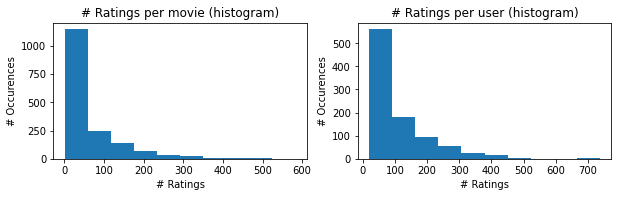

In [5]:
num_ratings_per_movie = count_ratings_per_movie(dataset)
num_ratings_per_user = count_ratings_per_user(dataset)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.5))
for ax, ratings, unit in zip(axes, (num_ratings_per_movie, num_ratings_per_user), ("movie", "user")):
    ax.hist(ratings.values())
    ax.set_title(f"# Ratings per {unit} (histogram)")
    ax.set_xlabel("# Ratings")
    ax.set_ylabel("# Occurences")

In [6]:
print("min # of movies per user = {}, \nmin # of users per movie = {}.".format(
        min(num_ratings_per_user.values()), min(num_ratings_per_movie.values())))

min # of movies per user = 20, 
min # of users per movie = 1.


# Remove movies with too few ratings

As is typical for real-life data, those distributions have a very long tail. There are some movies that have only one rating. Predictions for those will be very unreliable, so we want to take them out of the dataset.

In [7]:
def remove_rare_movies(dataset: Dataset, min_ratings_per_movie=10) -> Dataset:
    """Filter a dataset, and keep only movies with a minimum number of reviews
    
    Inputs:
        dataset: Dataset
        min_cases: int, the required minimum number
        
    Returns:
        new dataset: Dataset
    
    >>> test_dataset = Dataset(np.array([0, 0, 1]), np.array([0, 1, 1]), np.array([1.0, 1.0, 1.0]))
    >>> remove_rare_movies(test_dataset, 2)
    Dataset(movies=array([0, 0]), users=array([0, 1]), ratings=array([1., 1.]))
    """
    num_ratings_per_movie = count_ratings_per_movie(dataset)
    rare_movies = [key for key, value in num_ratings_per_movie.items() if value < min_ratings_per_movie]
    movies = np.delete(dataset.movies, np.where(np.isin(dataset.movies, rare_movies)))
    ratings = np.delete(dataset.ratings, np.where(np.isin(dataset.movies, rare_movies)))
    users = np.delete(dataset.users, np.where(np.isin(dataset.movies, rare_movies)))
    pruned_dataset = Dataset(movies=movies, ratings=ratings, users=users)
    return pruned_dataset

In [8]:
test(remove_rare_movies)

✅ Your `remove_rare_movies` passes some basic tests.


In [9]:
pruned_dataset = remove_rare_movies(dataset)
print(f"There are {len(pruned_dataset.ratings)} ratings left after pruning the dataset.")

There are 97953 ratings left after pruning the dataset.


# Split the data into a train and test set

In [10]:
def split_dataset(dataset, p_test = 0.1, seed = 1):
    """
    Split a dataset randomly into a train and a test part
    
    Inputs:
        dataset: Dataset
        p_test: float
            propability (0 < p_test < 1) for a data point to go into the test set
        seed: integer
        
    Returns:
        train_dataset: Dataset
        test_dataset: Dataset
    
    >>> split_dataset(Dataset(np.array([0, 0]), np.array([1, 0]), np.array([2.0, 1.0])), p_test=0)
    (Dataset(movies=array([0, 0]), users=array([1, 0]), ratings=array([2., 1.])), Dataset(movies=array([], dtype=int64), users=array([], dtype=int64), ratings=array([], dtype=float64)))
    
    >>> split_dataset(Dataset(np.array([0, 0]), np.array([1, 0]), np.array([2.0, 1.0])), p_test=1)
    (Dataset(movies=array([], dtype=int64), users=array([], dtype=int64), ratings=array([], dtype=float64)), Dataset(movies=array([0, 0]), users=array([1, 0]), ratings=array([2., 1.])))
    """
    # use this generator (https://numpy.org/doc/stable/reference/random/index.html)
    # you should use rng.uniform() once inside this function to match the automatic test case
    rng = np.random.default_rng(seed)
    test_indices = [i for i in range(len(dataset.movies)) if rng.uniform() <= p_test]
    train_movies = np.delete(dataset.movies, test_indices)
    train_ratings = np.delete(dataset.ratings, test_indices)
    train_users = np.delete(dataset.users, test_indices)
    train_data = Dataset(movies=train_movies, ratings=train_ratings, users=train_users)
    
    test_movies = dataset.movies[test_indices]
    test_ratings = dataset.ratings[test_indices]
    test_users = dataset.users[test_indices]
    test_data = Dataset(movies=test_movies, ratings=test_ratings, users=test_users)

    return train_data, test_data

In [11]:
test(split_dataset)

✅ Your `split_dataset` passes some basic tests.


In [12]:
train_data, test_data = split_dataset(pruned_dataset, p_test=0.1, seed=10)
print("Number of training points:", len(train_data.ratings))
print("Number of test points:", len(test_data.ratings))

Number of training points: 88354
Number of test points: 9599


# Visualize the dataset
So far, our data has been represented by a list of ratings. We will look at how we can interpret these ratings in a matrix (movies x users) and plot it.

In [13]:
def to_matrix(dataset, num_movies, num_users):
    """
    Construct a dense matrix out of the dataset.
    
    Input: 
        dataset: Dataset
    
    Output:
        matrix: np.array of floats: (# movies, # users) -> rating (float) or np.NaN if unavailable
    
    >>> to_matrix(Dataset(np.array([1, 1, 0]), np.array([0, 1, 0]), np.array([1.0, 3.0, 2.5])), 3, 2)
    array([[2.5, nan],
           [1. , 3. ],
           [nan, nan]])
    """
    m = np.zeros([num_movies, num_users]) * np.NaN  # We want NaNs for unavailable ratings
    for i in range(len(dataset.ratings)):
        m[dataset.movies[i], dataset.users[i]] = dataset.ratings[i]
    return m

In [14]:
test(to_matrix)

✅ Your `to_matrix` passes some basic tests.


Let's plot the train and test dataset 

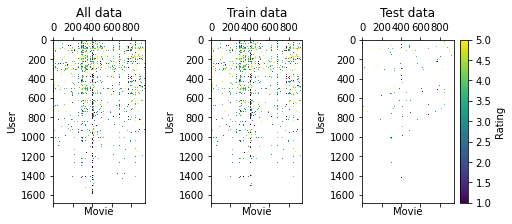

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
for ax, label, data in zip(axes, ("All data", "Train data", "Test data"), (dataset, train_data, test_data)):
    im = ax.matshow(to_matrix(data, num_movies, num_users))
    ax.set_title(label)
    ax.set_xlabel("Movie")
    ax.set_ylabel("User")
fig.colorbar(im, label="Rating");

# Comparing predictors

The goal of recommender systems is to fill in those matrices. In the remainder of this Notebook, we will implement different methods of making those predictions. Let's first develop the tools to compare them.

Our prediction methods will all have the following form:

In [16]:
class Predictor:
    def __init__(self, train_data: Dataset):
        # This is where you can do any preparation or 'training' if necessary.
        pass
    
    def __call__(self, test_data: Dataset):
        """
        Make predictions for the users and movies in the test dataset 
        (without looking at the ratings).
        
        Inputs:
            test_data: Dataset (with `n` entries)
        
        Output:
            predictions: np.array of floats, shape (`n`)
        """
        raise NotImplementedError()

 You would use a predictor like this as follows:
 
 ```
 p = Predictor(train_data)  # this initializes the model. This may include training.
 predictions = p(test_data)  # this calls `__call__` and makes a prediction.
 ```

As an example, a predictor that recommends the same rating everywhere would look like this:

In [17]:
class GlobalMeanPredictor(Predictor):
    """
    Always predict the mean rating from the training set
    
    >>> train_data = Dataset(np.array([1, 2, 3, 4]), np.array([1, 2, 3, 4]), np.array([1.0, 2.0, 2.0, 5.0]))
    >>> test_data = Dataset(np.array([1, 2, 3, 4]), np.array([2, 1, 4, 0]), np.array([4.0, 1.0, 1.0, 2.0]))
    >>> mean_predictor = GlobalMeanPredictor(train_data)
    >>> mean_predictor(test_data)
    array([2.5, 2.5, 2.5, 2.5])
    """
    def __init__(self, train_data: Dataset):
        ####################################
        ### ___ ENTER YOUR CODE HERE ___ ###
        ####################################
        self.mean = np.mean(train_data.ratings)

    def __call__(self, test_data: Dataset):
        return np.full_like(test_data.ratings, fill_value=self.mean)

In [18]:
test(GlobalMeanPredictor)

✅ Your `GlobalMeanPredictor` passes some basic tests.


We can evaluate the predictions using Mean Squared Error:

In [23]:
def mse(predictions, real_ratings):
    """Compute the mean squared prediction error
    
    Inputs:
        predictions: np.array of floats, shape (n)
        real_ratings: np.array of floats, shape (n)
    
    Returns:
        mean squared error: float
    
    >>> mse(np.array([1., 1.2, 2.]), np.array([2., 1., 1.5]))
    0.43
    >>> mse(np.array([4., 2., 1.]), np.array([4., 3., 1.]))
    0.3333333333333333
    """
    ####################################
    ### ___ Enter your code here ___ ###
    ####################################
    return np.sum(np.square(predictions - real_ratings))/len(predictions)

In [24]:
test(mse)

✅ Your `mse` passes some basic tests.


The error for the global mean predictor can now be computed:

In [25]:
predict_global_mean = GlobalMeanPredictor(train_data)

mse(predict_global_mean(test_data), test_data.ratings)

1.2454544657178057

It is always good to include simple baselines like this one in your machine learning experimentation. We now know that we should at least beat an MSE of `1.24` on the test set.

## Baselines 

We will now gradually make the baseline predictor more complex, by differentiating between users. The idea is that some users will give higher scores on average than others.

### User's mean prediction

Here, to predict the score for a tuple `(movie, user)`, we will return the  average all movie ratings of the `user`.

In [59]:
class UserMeanPredictor(Predictor):
    """
    Predict the mean rating of the user we are predicting for.
    
    >>> train_data = Dataset(np.array([1, 2, 3, 4]), np.array([1, 2, 2, 0]), np.array([1.0, 2.0, 2.5, 5.0]))
    >>> test_data = Dataset(np.array([1, 2, 3, 4]), np.array([2, 1, 1, 0]), np.array([4.0, 1.0, 1.0, 2.0]))
    >>> mean_predictor = UserMeanPredictor(train_data)
    >>> mean_predictor(test_data)
    array([2.25, 1.  , 1.  , 5.  ])
    """
    def __init__(self, train_data: Dataset):
        ####################################
        ### ___ Enter your code here ___ ###
        ####################################
        # Hint: don't worry about making this part fast.
        self.user_means = np.nanmean(to_matrix(train_data, np.max(train_data.movies) + 1, np.max(train_data.users) + 1), axis=0)

    def __call__(self, test_data: Dataset):
        ####################################
        ### ___ Enter your code here ___ ###
        ####################################
        preds = []
        for user in test_data.users:
            preds.append(self.user_means[user])
        return np.array(preds)

In [60]:
test(UserMeanPredictor)

✅ Your `UserMeanPredictor` passes some basic tests.


Is this working better than predicting the global mean?

In [61]:
predict_user_mean = UserMeanPredictor(train_data)

mse(predict_user_mean(test_data), test_data.ratings)

1.082106040332895

Q: Why would always predicting the user's mean be pretty useless in practice?

Q: If you want, you can improve the predictor by falling back to the global mean in case we haven't seen any ratings of a user before (or not enough of them).

### Movie's mean prediction

Here, to predict the score for a tuple `(movie, user)`, we will return the  average all movie ratings of the `movie`. 

Under what assumption is this a good model?

In [64]:
class MovieMeanPredictor(Predictor):
    """
    Predict the mean rating of the movie, irrespective of the user
    
    >>> train_data = Dataset(np.array([0, 0, 1, 1, 2]), np.array([1, 2, 3, 4, 5]), np.array([4.0, 1.0, 1.0, 2.0, 1.0]))
    >>> test_data = Dataset(np.array([0, 1, 2, 1]), np.array([1, 2, 2, 0]), np.array([1.0, 2.0, 2.5, 5.0]))
    >>> mean_predictor = MovieMeanPredictor(train_data)
    >>> mean_predictor(test_data)
    array([2.5, 1.5, 1. , 1.5])
    """
    def __init__(self, train_data: Dataset):
        ####################################
        ### ___ Enter your code here ___ ###
        ####################################
        # Hint: don't worry about making this part fast.
        self.movie_means = np.nanmean(to_matrix(train_data, np.max(train_data.movies) + 1, np.max(train_data.users) + 1), axis=1)

    def __call__(self, test_data: Dataset):
        ####################################
        ### ___ Enter your code here ___ ###
        ####################################
        preds = []
        for movie in test_data.movies:
            preds.append(self.movie_means[movie])
        return np.array(preds)

In [65]:
test(MovieMeanPredictor)

✅ Your `MovieMeanPredictor` passes some basic tests.


In [66]:
predict_movie_mean = MovieMeanPredictor(train_data)

mse(predict_movie_mean(test_data), test_data.ratings)

/Users/Julian/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


1.0125633530609897

### Matrix Factorization

With those baselines, we can implement a more realistic recommendation model that using Matrix Factorization.

- To each movie $i$ in the dataset, we will assign a $d$-dimensional trainable ‘representation vector’ $\mathbf{m}_i$.
- To each user $j$ in the dataset, we will assign a $d$-dimensional trainable ‘representation vector’ $\mathbf{u}_j$.
- You can summarize those representations in two matrices: $\mathbf{M}$ of size `(#movies, d)`, and $\mathbf{U}$ of size `(#users, d)`.
- The predicted score we will give for a movie $i$ and a user $j$ will be the dot product $\mathbf{m}_i \cdot \mathbf{u}_j$.
- You can simultaneously express the predicted scores for all movies and all users as a matrix of size `(#movies, #users)` as the matrix product $\mathbf{M} \mathbf{U}^\top$. This interpretation gives the name to this model.
- Given a training set $T$ with rating triples `(movie i, user j, rating r)`,
  we will optimize the mean squared prediction error $\frac{1}{|T|}\sum_{(i, j, r) \in T} (\mathbf{m}_i \cdot \mathbf{u}_j - r)^2$ over the training set. 

In [82]:
class MatrixFactorizationPredictor(Predictor):
    """
    Predict the rating of a user/movie pair as the dot-product 
    of representation vectors of the user and the movie.
    
    >>> train_data = Dataset(np.array([0, 0, 1, 1, 2]), np.array([1, 2, 3, 4, 5]), np.array([4.0, 1.0, 1.0, 2.0, 1.0]))
    >>> test_data = Dataset(np.array([0, 1, 2, 1]), np.array([1, 2, 2, 0]), np.array([1.0, 2.0, 2.5, 5.0]))
    >>> mean_predictor = MatrixFactorizationPredictor(train_data)
    >>> mean_predictor(test_data)  # the factorization is not yet optimized here
    array([ 2.62654714, -2.89866225,  0.70909287,  5.29901482])
    """
    def __init__(self, train_data: Dataset, num_features=20, seed=1):
        # Randomly initialize features for the users and the movies from N(0, 1)
        
        # use this generator (https://numpy.org/doc/stable/reference/random/index.html)
        # you are expected to use rng.normal() twice in this function to match the tests, once for movies, and then once for users
        rng = np.random.default_rng(seed)  
        
        num_movies = np.max(train_data.movies) + 1
        num_users = np.max(train_data.users) + 1
        ####################################
        ### ___ ENTER YOUR CODE HERE ___ ###
        ####################################
        self.movie_features = np.zeros((num_movies, num_features))
        self.user_features = np.zeros((num_users, num_features))
        
        for i in range(num_movies):
            for j in range(num_features):
                self.movie_features[i, j] = rng.normal()
        for i in range(num_users):
            for j in range(num_features):
                self.user_features[i, j] = rng.normal()
        # Normally, you should train the model here, but we will skip this
        # for now, to be able to take it step-by-step.
        
    def __call__(self, test_data: Dataset):
        ####################################
        ### ___ Enter your code here ___ ###
        ####################################
        preds = []
        for i in range(len(test_data.movies)):
            preds.append(np.sum(self.movie_features[test_data.movies[i],:] * self.user_features[test_data.users[i],:]))
        return np.array(preds)

In [83]:
test(MatrixFactorizationPredictor)

✅ Your `MatrixFactorizationPredictor` passes some basic tests.


Without training, the `MatrixFactorizationPredictor` would not perform so well:

In [69]:
predict_global_mean = MatrixFactorizationPredictor(train_data)

mse(predict_global_mean(test_data), test_data.ratings)

34.84973825903476

### Optimize the factorization using SGD

One way to optimize the representation vectors for movies and users, is to sample terms from the following loss function:

$$\frac{1}{|T|}\sum_{(i, j, r) \in T} (\mathbf{m}_i \cdot \mathbf{u}_j - r)^2$$

and optimize the sampled $\mathbf{m}_i$ and $\mathbf{u}_j$ using a stochastic gradient descent step.

To improve generalization, we will add L2 regularization (also known as `weight decay`) to this model, both for the movie representations as well as for the user representations. Because those weights are unique for each movie / user, you should also sample those stochastically. If you sample a triple `(i, j, r)`, you should minimize:

$$ (\mathbf{m}_i \cdot \mathbf{u}_j - r)^2 + \lambda_\text{movie} \left\lVert\mathbf{m}_i\right\rVert^2 + \lambda_\text{user} \left\lVert\mathbf{u}_j\right\rVert^2$$

You should start by computing a gradient for this term.

In [88]:
learning_rate = 0.02
weight_decay_movie = 0.3
weight_decay_user = 0.3

predictor = MatrixFactorizationPredictor(train_data)
rng = np.random.default_rng(0)
for epoch in range(20):
    # Shuffle the dataset
    datapoint_indices = rng.permutation(len(train_data.ratings))
    print(len(datapoint_indices))
    i = 0
    for point in datapoint_indices:
        i+= 1
        #print(i)
        movie = train_data.movies[point]
        user = train_data.users[point]
        rating = train_data.ratings[point]

        # Optimize the factorizations in `predictor` using an SGD
        # step based on the datapoint (movie, user, rating).
        ####################################
        ### ___ Enter your code here ___ ###
        ####################################
        pred_data = Dataset(movies=np.array([movie]), users=np.array([user]), ratings=np.array([rating]))
        pred = predictor(pred_data)
        
        user_feats = predictor.user_features[user,:]
        movie_feats = predictor.movie_features[movie, :]
        
        movie_grad = 2 * (pred - rating) * user_feats + 2 * weight_decay_movie * movie_feats
        user_grad = 2 * (pred - rating) * movie_feats + 2 * weight_decay_user * user_feats     
        predictor.movie_features[movie, :] = predictor.movie_features[movie, :] - learning_rate * movie_grad
        predictor.user_features[user, :] = predictor.user_features[user,:] - learning_rate * user_grad
    
    learning_rate *= 0.9  # decay the learning rate after each epoch
        
    print(f"Train error after epoch {epoch+1}: {mse(predictor(train_data), train_data.ratings)}")
    print(f"Test error after epoch {epoch+1}: {mse(predictor(test_data), test_data.ratings)}")

88354
Train error after epoch 1: 1.016629537857666
Test error after epoch 1: 1.2475848138682906
88354
Train error after epoch 2: 0.964773115360917
Test error after epoch 2: 1.1056875689807846
88354
Train error after epoch 3: 0.9836863756146063
Test error after epoch 3: 1.0906516244178521
88354
Train error after epoch 4: 0.9582321527468947
Test error after epoch 4: 1.0432114339126781
88354
Train error after epoch 5: 0.9496612899623846
Test error after epoch 5: 1.0260021535034913
88354
Train error after epoch 6: 0.9523995653328032
Test error after epoch 6: 1.0217308353750343
88354
Train error after epoch 7: 0.9452059927916077
Test error after epoch 7: 1.0064437975692968
88354
Train error after epoch 8: 0.9489052302635196
Test error after epoch 8: 1.0073038868984543
88354
Train error after epoch 9: 0.9453595957775589
Test error after epoch 9: 1.0049696286651164
88354
Train error after epoch 10: 0.9412862857266382
Test error after epoch 10: 0.9946411672980414
88354
Train error after epoch 

You should expect the test error to go down below 1.0.

Feel free to play with the weight decay parameters and learning rates to improve these results.

### Optimize the factoriziation using Alternating Least Squares

Instead of optimizing the objective

$$\frac{1}{|T|}\sum_{(i, j, r) \in T} (\mathbf{m}_i \cdot \mathbf{u}_j - r)^2 + \lambda_\text{movie} \left\lVert \mathbf{M} \right\rVert^2_\text{F} + \lambda_\text{user} \left\lVert \mathbf{U} \right\rVert^2_\text{F}$$

using SGD by sampling terms, we can also use ‘Alternating Least Squares’. For ALS, we make the observation that, if all users representations $\mathbf{u}_j$ are fixed, optimizing all $\mathbf{m}_i$ is a simple least squares problem. Similarly, if the movie representations $\mathbf{m}_i$ are all fixed, optimizing all $\mathbf{u}_j$ is a simple least squares problem. 

What we will do here, is alternate between the following steps:
- Fix the user representations, and perfectly optimize the movie representations.
- Fix the movie representations, and perfectly optimize the user representations.

In [110]:
movie_regularization = 20
user_regularization = 20
max_iterations = 1000
stop_criterion = 1e-4

predictor = MatrixFactorizationPredictor(train_data)
user_features = predictor.user_features
movie_features = predictor.movie_features
rng = np.random.default_rng(0)

prev_train_error = None

for iteration in range(max_iterations):

    # Optimize the user features
    for user in np.unique(train_data.users):
        # Update `user_features[user]` by optimizing the regularized corresponding least squares objective
        mask = train_data.users == user
        user_movies = train_data.movies[mask]
        user_ratings = train_data.ratings[mask]
        user_movie_features = movie_features[user_movies]
        left = (user_movie_features.T @ user_movie_features) + movie_regularization * np.identity(user_movie_features.shape[1])
        right = user_movie_features.T @ user_ratings
        new_user_feats = np.linalg.solve(left, right)
        user_features[user] = new_user_feats
        #print(new_user_feats)
    
    # Optimize the movie features using least squares
    for movie in np.unique(train_data.movies):
        # Update `movie_features[movie]` by optimizing the regularized corresponding least squares objective
        mask = train_data.movies == movie
        movie_users = train_data.users[mask]
        user_ratings = train_data.ratings[mask]
        movie_user_features = user_features[movie_users]
        left = (movie_user_features.T @ movie_user_features) + user_regularization * np.identity(movie_user_features.shape[1])
        right = movie_user_features.T @ user_ratings
        new_movie_feats = np.linalg.solve(left, right)
        #print(new_movie_feats)
        movie_features[movie] = new_movie_feats 
        
    train_error = mse(predictor(train_data), train_data.ratings)
    print(f"Train error after step {iteration+1}: {train_error}")
    print(f"Test error after step {iteration+1}: {mse(predictor(test_data), test_data.ratings)}")
    
    # Stop if the training error is not going down more than 'stop_criterion'
    if prev_train_error is not None and prev_train_error - train_error <= stop_criterion:
        break
    prev_train_error = train_error

Train error after step 1: 4.2795331256791895
Test error after step 1: 5.102430270237264
Train error after step 2: 1.1932472707800694
Test error after step 2: 1.3986097947816118
Train error after step 3: 0.9855487724785076
Test error after step 3: 1.1496391854680805
Train error after step 4: 0.89804499280623
Test error after step 4: 1.0506121953125507
Train error after step 5: 0.8574256721668729
Test error after step 5: 1.0062031489713599
Train error after step 6: 0.8360784488703847
Test error after step 6: 0.9839060950439644
Train error after step 7: 0.8234798339164903
Test error after step 7: 0.9715267097203488
Train error after step 8: 0.8153475190130611
Test error after step 8: 0.9640884654623995
Train error after step 9: 0.8097499811682943
Test error after step 9: 0.9593523736646232
Train error after step 10: 0.8057310417941411
Test error after step 10: 0.9562111979413074
Train error after step 11: 0.8027671605229696
Test error after step 11: 0.9540680352069967
Train error after st

You should find that this beats the simple baselines.
Using default SGD parameters, the alternating least squares solution here outperforms it, but by tuning SGD carefully, you should be able to get the same quality.